# Models

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from utils import *

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, LassoLarsCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool, cv

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.inspection import permutation_importance

In [2]:
df = pd.read_csv('./data_prepared.csv')

In [6]:
df.nunique()

Company Location                      63
Review Date                           15
Country of Bean Origin                56
Specific Bean Origin or Bar Name    1436
Cocoa Percent                         46
Rating                                13
Continent_company                      5
Sub-region_company                    13
Continent_origin                       5
Sub-region_origin                     10
Manufacturer                         493
Company                              527
isBlend                                2
nutty                                  2
fruit                                  2
floral                                 2
spicy                                  2
cocoa                                  2
earthy                                 2
sweet                                  2
sour                                   2
roasty                                 2
dairy                                  2
grass                                  2
pungent         

In [7]:
# Split into train/test
X = df.drop('Rating', axis=1)
y = df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
cat_enc = CatEncoder('GLMMEncoder', cols=['Specific Bean Origin or Bar Name', 
                                              'Manufacturer', 
                                              'Company'])
cat_enc.fit(X_train, y_train)

X_trans = cat_enc.transform(X, y)
df_trans = pd.concat([X_trans, y], axis=1)
df_trans = pd.get_dummies(df_trans, prefix_sep='_')

X_trans = df_trans.drop('Rating', axis=1)
y_trans = df_trans['Rating']
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans, test_size=0.3, random_state=42)

In [12]:
num_columns = ['Review Date', 'Cocoa Percent']
num_enc = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns)],
    remainder='passthrough')

## Correlations

In [61]:
X = df.drop('Rating', axis=1)
y = df['Rating']

cat_enc = CatEncoder('CatBoostEncoder')
cat_enc.fit(X, y)

X_trans = cat_enc.transform(X, y)
df_trans = pd.concat([X_trans, y], axis=1)

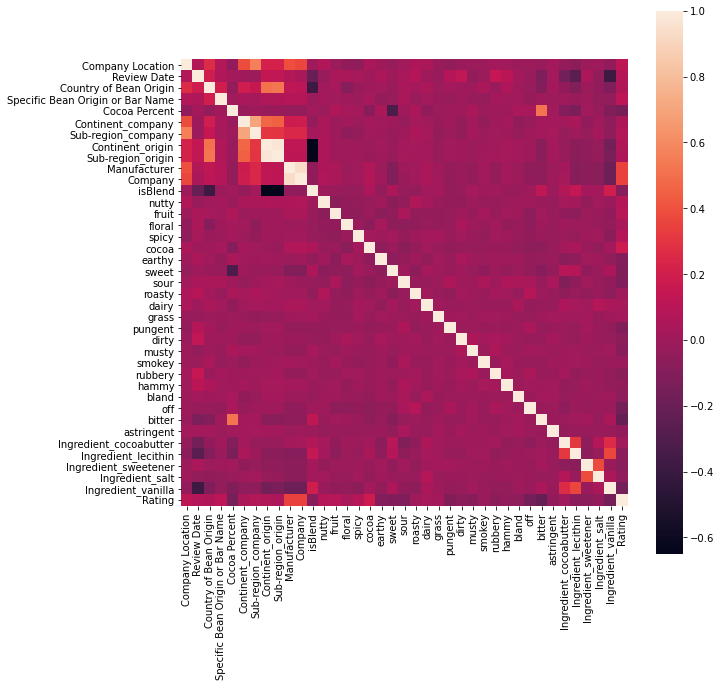

In [62]:
corrmat = df_trans.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, square=True);

In [63]:
corrmat.loc[(np.abs(corrmat) > 0.7).sum() > 1, (np.abs(corrmat) > 0.7).sum() > 1]

,Continent_company,Sub-region_company,Continent_origin,Sub-region_origin,Manufacturer,Company
Continent_company,1.000000,0.701543,0.464682,0.446239,0.178249,0.184492
Sub-region_company,0.701543,1.000000,0.307422,0.302122,0.241261,0.239434
Continent_origin,0.464682,0.307422,1.000000,0.977568,0.125222,0.126744
Sub-region_origin,0.446239,0.302122,0.977568,1.000000,0.118975,0.118264
Manufacturer,0.178249,0.241261,0.125222,0.118975,1.000000,0.938373
Company,0.184492,0.239434,0.126744,0.118264,0.938373,1.000000


In [64]:
# Drop Continent_company, Continent_origin, Manufacturer
df = df.drop(['Continent_company', 'Continent_origin', 'Manufacturer'], axis=1)

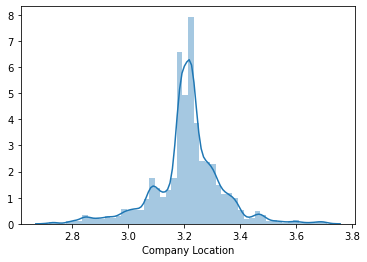

In [81]:
sns.distplot(df_trans['Company Location'])

In [84]:
list(zip(axs, df_trans.columns[:3]))

[(<matplotlib.axes._subplots.AxesSubplot at 0x265243b8d08>,
  'Company Location'),
 (<matplotlib.axes._subplots.AxesSubplot at 0x26524362888>, 'Review Date'),
 (<matplotlib.axes._subplots.AxesSubplot at 0x26522da2288>,
  'Country of Bean Origin')]

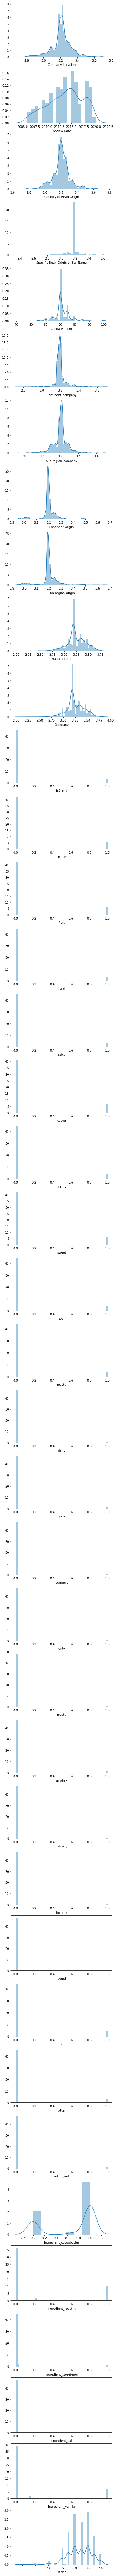

In [89]:
fig, axs = plt.subplots(len(df_trans.columns), figsize=(6, len(df_trans.columns)*4))

for ax, col in zip(axs, df_trans.columns):
    sns.distplot(df_trans[col], ax=ax)
plt.show()

## Preprocessing

In [15]:
# Split into train/test
X = df.drop('Rating', axis=1)
y = df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Encode categorical features and normalize numerical features.

In [50]:
encoders = ['CatBoostEncoder', 'GLMMEncoder', 'JamesSteinEncoder', 
            'LeaveOneOutEncoder', 'MEstimateEncoder', 'TargetEncoder', 
            'BinaryEncoder', 'HashingEncoder', 'OrdinalEncoder']

class CatEncoder(TransformerMixin):
    def __init__(self, enc_name='MEstimateEncoder', **kwargs):
        exec('from category_encoders import %s' % enc_name)
        exec('self.encoder = %s(**kwargs)' % enc_name)
    
    def fit(self, X, y=None):
        return self.encoder.fit(X, y)
    
    def transform(self, X, y=None):
        return self.encoder.transform(X, y)
    
    def set_params(self, **params):
        print(params)
        return self.encoder.set_params(**params)

In [51]:
num_columns = ['Review Date', 'Cocoa Percent']
cat_columns = df.select_dtypes(exclude='number').columns.tolist()

# Categorical encoding
#cat_enc = CatEncoder()
#cat_enc.fit(X_train, y_train)

#X_train_trans = cat_enc.transform(X_train, y_train)
#X_test_trans = cat_enc.transform(X_test, y_test)

# Normalize numerical columns
num_enc = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns)],
    remainder='passthrough')
#num_enc.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['Review Date', 'Cocoa Percent'])])

In [8]:
# Utility function for evaluation
def eval_mod(model):
    y_pred = model.predict(X_test)
    
    print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('MAE:', mean_absolute_error(y_test, y_pred))
    print('R^2:', r2_score(y_test, y_pred))

# Evaluate encoders
def eval_encoders(model):
    scores = []
    for enc in encoders:
        pipeline = Pipeline([('cat_enc', CatEncoder(enc)), 
                             ('scaler', num_enc), 
                             ('mod', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(rmse)
    
    return pd.Series(scores, index=encoders).sort_values()

In [9]:
feature_names = X_train.columns

## Feature selection

In [41]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

sel_mod = Pipeline([('scaler', num_enc), 
                    ('sel', SelectKBest()), 
                    ('regr', SVR())])

params = {'sel__score_func': [f_regression], 
          'sel__k': ['all']}

gs = GridSearchCV(sel_mod, params, 
                  cv=5, 
                  scoring='neg_root_mean_squared_error', 
                  return_train_score=True,
                  n_jobs=-1,
                  verbose=3)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Review '
                                                                          'Date',
                                                                          'Cocoa '
                                                                          'Percent'])])),
                                       ('sel', SelectKBest()),
                                       ('regr', SVR())]),
             n_jobs=-1,
             param_grid={'sel__k': ['all'],
                         'sel__score_func': [<function f_regression at 0x0000020789254048>]},
             return_train_score=True, scoring='neg_root

In [42]:
# Show best parameters
gs.best_params_

{'sel__k': 'all',
 'sel__score_func': <function sklearn.feature_selection._univariate_selection.f_regression(X, y, *, center=True)>}

In [43]:
# Compare the train and test scores
results = pd.DataFrame(gs.cv_results_)
results.loc[results['mean_test_score'] == gs.best_score_, ['mean_train_score', 'mean_test_score']]

,mean_train_score,mean_test_score
0,-0.194181,-0.312177


In [46]:
best_mod = gs.best_estimator_.fit(X_train, y_train)

In [47]:
eval_mod(best_mod, X_test, y_test)

RMSE: 0.3893857448467128
MAE: 0.30358213855762056
R^2: 0.30221288487792586


## Linear regression

In [70]:
eval_encoders(LinearRegression())

HashingEncoder        0.407686
OrdinalEncoder        0.409267
LeaveOneOutEncoder    0.409337
CatBoostEncoder       0.409455
TargetEncoder         0.409907
BinaryEncoder         0.411371
JamesSteinEncoder     0.422799
GLMMEncoder           0.423760
MEstimateEncoder      0.432069
dtype: float64

In [71]:
lr_mod = Pipeline([('cat_enc', CatEncoder('CatBoostEncoder')), 
                   ('scaler', num_enc), 
                   ('lr', LinearRegression())])
lr_mod.fit(X_train, y_train)

Pipeline(steps=[('cat_enc', <__main__.CatEncoder object at 0x0000026522DB6D48>),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Review Date',
                                                   'Cocoa Percent'])])),
                ('lr', LinearRegression())])

In [72]:
eval_mod(lr_mod)

RMSE: 0.4094546535037248
MAE: 0.3172092368121007
R^2: 0.22843153015937767


In [72]:
coefs = pd.DataFrame({'feature': feature_names, 'coef': lr_mod['lr'].coef_})
coefs['abs_coef'] = np.abs(coefs['coef'])
coefs.sort_values('abs_coef', ascending=False).drop('abs_coef', axis=1)

,feature,coef
4,Cocoa Percent,0.650457
7,Continent_origin,0.637516
10,Company,0.485254
9,Manufacturer,0.464666
3,Specific Bean Origin or Bar Name,0.254839
27,rubbery,-0.211428
23,pungent,-0.210102
28,hammy,-0.183995
24,dirty,-0.181694
6,Sub-region_company,0.176973


### Lasso regression

In [73]:
eval_encoders(LassoCV(max_iter=2000))

HashingEncoder        0.407700
BinaryEncoder         0.410188
CatBoostEncoder       0.411044
LeaveOneOutEncoder    0.411105
TargetEncoder         0.411717
GLMMEncoder           0.423710
JamesSteinEncoder     0.424163
MEstimateEncoder      0.433753
OrdinalEncoder        0.435107
dtype: float64

In [102]:
lasso_mod = Pipeline([('scaler', num_enc), 
                    ('lasso', LassoCV(alphas=np.logspace(-2, 2, num=20), cv=10, max_iter=2000))])

lasso_mod.fit(X_train, y_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Review Date',
                                                   'Cocoa Percent'])])),
                ('lasso',
                 LassoCV(alphas=array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02]),
                         cv=10, max_iter=2000))])

In [103]:
lasso_mod['lasso'].alpha_

0.01

In [104]:
eval_mod(lasso_mod, X_train, y_train)

RMSE: 0.29699416298418857
MAE: 0.2325367008819721
R^2: 0.5553225648187039


In [105]:
eval_mod(lasso_mod, X_test, y_test)

RMSE: 0.4280088818234819
MAE: 0.3357138707779987
R^2: 0.15692072762225873


In [84]:
coefs = pd.DataFrame({'feature': feature_names, 'coef': lasso_mod['lasso'].coef_})
coefs['abs_coef'] = np.abs(coefs['coef'])
coefs.sort_values('abs_coef', ascending=False).drop('abs_coef', axis=1)

ValueError: arrays must all be same length

### Ridge regression

In [ ]:
eval_encoders(RidgeCV(alphas=np.logspace(-2, 2, num=5)))

In [84]:
ridge_mod = Pipeline([('scaler', num_enc), 
                    ('ridge', RidgeCV(alphas=np.logspace(-2, 2, num=20), cv=10))])

ridge_mod.fit(X_train, y_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Review Date',
                                                   'Cocoa Percent'])])),
                ('ridge',
                 RidgeCV(alphas=array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02]),
                         cv=10))])

In [85]:
ridge_mod['ridge'].alpha_

1.2742749857031335

In [86]:
eval_mod(ridge_mod, X_train, y_train)

RMSE: 0.2555000453145923
MAE: 0.19457998076106697
R^2: 0.6708974652951124


In [87]:
eval_mod(ridge_mod, X_test, y_test)

RMSE: 0.4191599343364928
MAE: 0.3233929557004117
R^2: 0.19142115129900794


## SVM

In [88]:
eval_encoders(SVR())

GLMMEncoder           0.396141
CatBoostEncoder       0.401887
TargetEncoder         0.402645
LeaveOneOutEncoder    0.403652
BinaryEncoder         0.406927
HashingEncoder        0.413892
MEstimateEncoder      0.414953
JamesSteinEncoder     0.420034
OrdinalEncoder        0.480944
dtype: float64

In [58]:
svr_mod = Pipeline([('cat_enc', CatEncoder('GLMMEncoder')), 
                   ('scaler', num_enc), 
                   ('svr', SVR())])
svr_mod.fit(X_train, y_train)

Pipeline(steps=[('cat_enc', <__main__.CatEncoder object at 0x0000020935307C08>),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Review Date',
                                                   'Cocoa Percent'])])),
                ('svr', SVR())])

In [32]:
svr_mod = Pipeline([('scaler', num_enc), 
                    ('sel', SelectKBest(score_func=f_regression, k='all')), 
                    ('regr', SVR())])
svr_mod.fit(X_train, y_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Review Date',
                                                   'Cocoa Percent'])])),
                ('sel',
                 SelectKBest(k='all',
                             score_func=<function f_regression at 0x0000020789254048>)),
                ('regr', SVR())])

In [34]:
eval_mod(svr_mod, X_test, y_test)

RMSE: 0.3893857448467128
MAE: 0.30358213855762056
R^2: 0.30221288487792586


In [35]:
params = {'regr__kernel': ['rbf', 'linear', 'poly'], 
          'regr__C': [0.03, 0.1, 0.3, 1, 3], 
          'regr__epsilon': [0.03, 0.1, 0.3, 1]}

gs = GridSearchCV(svr_mod, params, 
                  cv=5, 
                  scoring='neg_root_mean_squared_error', 
                  return_train_score=True,
                  n_jobs=-1,
                  verbose=3)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Review '
                                                                          'Date',
                                                                          'Cocoa '
                                                                          'Percent'])])),
                                       ('sel',
                                        SelectKBest(k='all',
                                                    score_func=<function f_regression at 0x0000020789254048>)),
                                       ('regr', SVR())]),
             n_jobs=-1,
             param_grid={'regr__C': 

In [36]:
# Show best parameters
gs.best_params_

{'regr__C': 0.3, 'regr__epsilon': 0.03, 'regr__kernel': 'linear'}

In [37]:
# Compare the train and test scores
results = pd.DataFrame(gs.cv_results_)
results.loc[results['mean_test_score'] == gs.best_score_, ['mean_train_score', 'mean_test_score']]

,mean_train_score,mean_test_score
25,-0.255925,-0.278048


In [38]:
svr_best_mod = gs.best_estimator_.fit(X_trans, y_trans)

In [40]:
eval_mod(svr_best_mod, X_test, y_test)

RMSE: 0.40122366464699993
MAE: 0.30121191141520204
R^2: 0.25914037081081487


In [8]:
eval_encoders(SVR(C=1, epsilon=0.1, kernel='rbf'))

GLMMEncoder           0.388660
CatBoostEncoder       0.401977
TargetEncoder         0.402894
LeaveOneOutEncoder    0.405017
MEstimateEncoder      0.407155
BinaryEncoder         0.412357
HashingEncoder        0.416556
JamesSteinEncoder     0.431125
OrdinalEncoder        0.470190
dtype: float64

## Random Forest

In [10]:
eval_encoders(RandomForestRegressor(random_state=42, max_depth=7))

BinaryEncoder         0.410112
HashingEncoder        0.410256
OrdinalEncoder        0.416301
LeaveOneOutEncoder    0.416642
TargetEncoder         0.417682
CatBoostEncoder       0.418458
GLMMEncoder           0.441413
MEstimateEncoder      0.443260
JamesSteinEncoder     0.446120
dtype: float64

In [106]:
rf_mod = Pipeline([('scaler', num_enc), 
                   ('rf', RandomForestRegressor(random_state=42, 
                                                n_jobs=-1, 
                                                n_estimators=200))])

params = {'rf__max_depth': [20], 
          'rf__min_samples_split': [10], 
          'rf__min_samples_leaf': [2, 3], 
          'rf__max_leaf_nodes': [None, 150], 
          'rf__max_features': ['auto']}

gs = GridSearchCV(rf_mod, params, 
                  cv=5, 
                  scoring='neg_root_mean_squared_error', 
                  return_train_score=True,
                  n_jobs=-1,
                  verbose=3)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:   15.4s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   18.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Review '
                                                                          'Date',
                                                                          'Cocoa '
                                                                          'Percent'])])),
                                       ('rf',
                                        RandomForestRegressor(n_estimators=200,
                                                              n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__ma

In [107]:
# Show best parameters
gs.best_params_

{'rf__max_depth': 20,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 10}

In [108]:
# Compare the train and test scores
results = pd.DataFrame(gs.cv_results_)
results.loc[results['mean_test_score'] == gs.best_score_, ['mean_train_score', 'mean_test_score']]

,mean_train_score,mean_test_score
0,-0.145026,-0.236646


In [109]:
rf_best_mod = gs.best_estimator_

In [110]:
eval_mod(rf_best_mod, X_test, y_test)

RMSE: 0.4421699363457846
MAE: 0.34252211774503244
R^2: 0.10020977380478047


In [16]:
(rf_best_mod['rf'].estimators_[0].tree_.children_left<0).sum()

189

### Feature importance

In [52]:
pi = permutation_importance(lr_mod, X_train, y_train, 
                            n_repeats=10, random_state=42)

In [53]:
perm_sorted_idx = (-pi.importances_mean).argsort()

In [54]:
importances = pd.DataFrame(pi.importances[perm_sorted_idx].T, columns=feature_names[perm_sorted_idx])
importances.iloc[:, :3]

,Company,Manufacturer,Specific Bean Origin or Bar Name
0,0.125105,0.119416,0.078776
1,0.083690,0.077070,0.071739
2,0.112418,0.102213,0.064858
3,0.118817,0.108759,0.061722
4,0.100641,0.092273,0.068414
5,0.106091,0.097739,0.070817
6,0.108432,0.098974,0.076222
7,0.109429,0.102258,0.071143
8,0.109787,0.104547,0.062118
9,0.110567,0.099620,0.078315


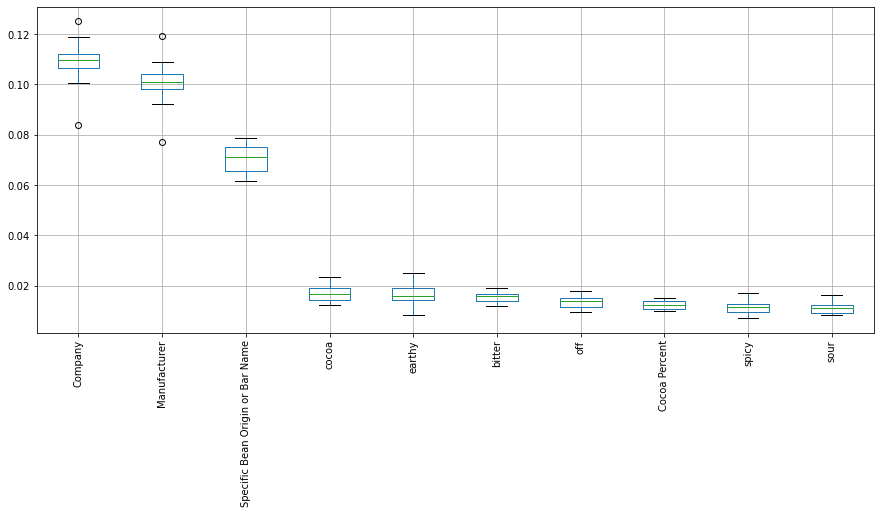

In [55]:
fig, ax = plt.subplots(figsize=(15, 6))
importances.iloc[:, :10].boxplot()
plt.xticks(rotation=90);

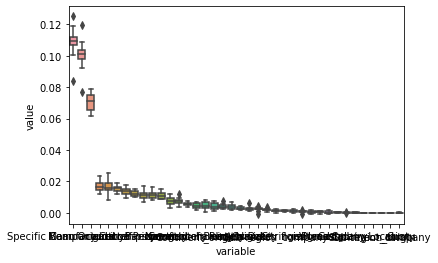

In [56]:
sns.boxplot(x="variable", y="value", data=pd.melt(importances));

In [57]:
importances = pd.DataFrame({'feature': feature_names, 
                            'importances_mean': pi.importances_mean, 
                            'importances_std': pi.importances_std})
importances.sort_values('importances_mean', ascending=False)[:15]

,feature,importances_mean,importances_std
10,Company,0.108498,0.010428
9,Manufacturer,0.100287,0.010370
3,Specific Bean Origin or Bar Name,0.070412,0.005897
16,cocoa,0.016952,0.003560
17,earthy,0.016918,0.004675
31,bitter,0.015323,0.002204
30,off,0.013574,0.002423
4,Cocoa Percent,0.012363,0.001845
15,spicy,0.011369,0.002693
19,sour,0.011280,0.002380


# CatBoost

In [3]:
# Split into train/test
X = df.drop('Rating', axis=1)
y = df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
cat_features = X_train.select_dtypes(exclude='number')

params = {'loss_function': 'RMSE', 
          'eval_metric': 'RMSE', 
          'iterations': 600, 
          'random_seed': 42, 
          'learning_rate': 0.1, 
          'l2_leaf_reg': 30, 
          'depth': 8, 
          'od_type': 'Iter', 
          'od_wait': 20, 
          #'od_pval': 1e-5, 
          'use_best_model': True, 
          'verbose': 10}

cv_data = cv(
    Pool(X_train, y_train, cat_features=cat_features),
    params,
    fold_count=10, 
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.9163487	test: 2.9147048	best: 2.9147048 (0)	total: 361ms	remaining: 3m 36s
10:	learn: 1.1990312	test: 1.1690264	best: 1.1690264 (10)	total: 7.82s	remaining: 6m 58s
20:	learn: 0.6136396	test: 0.5808405	best: 0.5808405 (20)	total: 13.5s	remaining: 6m 12s
30:	learn: 0.4676064	test: 0.4464938	best: 0.4464938 (30)	total: 20.5s	remaining: 6m 17s
40:	learn: 0.4298546	test: 0.4182082	best: 0.4182082 (40)	total: 29.4s	remaining: 6m 40s
50:	learn: 0.4106407	test: 0.4057959	best: 0.4057959 (50)	total: 40.2s	remaining: 7m 13s
60:	learn: 0.3994257	test: 0.4001245	best: 0.4001245 (60)	total: 52.2s	remaining: 7m 40s
70:	learn: 0.3911489	test: 0.3959110	best: 0.3959110 (70)	total: 1m 5s	remaining: 8m 6s
80:	learn: 0.3843255	test: 0.3929216	best: 0.3929216 (80)	total: 1m 18s	remaining: 8m 25s
90:	learn: 0.3775865	test: 0.3900450	best: 0.3900450 (90)	total: 1m 33s	remaining: 8m 42s
100:	learn: 0.3715562	test: 0.3877966	best: 0.3877966 (100)	total: 1m 48s	remaining: 8m 58s
110:	learn: 0.36589

KeyboardInterrupt: 

In [33]:
min_index = np.argmin(cv_data['test-RMSE-mean'])

print('Best validation RMSE score: {:.2f}±{:.2f} on step {}'.format(
    cv_data['test-RMSE-mean'][min_index],
    cv_data['test-RMSE-std'][min_index],
    min_index)
)
print('Train RMSE score: {:.2f}±{:.2f} on step {}'.format(
    cv_data['train-RMSE-mean'][min_index],
    cv_data['train-RMSE-std'][min_index],
    min_index)
)

Best validation RMSE score: 0.37±0.02 on step 331
Train RMSE score: 0.30±0.00 on step 331


In [56]:
params = {'loss_function': 'RMSE', 
          'eval_metric': 'RMSE', 
          'iterations': 600, 
          'random_seed': 42, 
          'od_type': 'Iter', 
          'od_wait': 20}
          #'od_pval': 1e-5'verbose': 50}

cb_mod = CatBoostRegressor(**params)

grid = {'learning_rate': [0.3, 0.4], 
        'l2_leaf_reg': [18, 20, 22], 
        'depth': [5, 6]}

grid_search_result = cb_mod.grid_search(grid, 
                            X=Pool(X_train, y_train, cat_features=cat_features), 
                            cv=10, 
                            plot=True, 
                            verbose=50)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3649250856
bestIteration = 143

0:	loss: 0.3649251	best: 0.3649251 (0)	total: 4.85s	remaining: 53.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3606332564
bestIteration = 100

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.354665089
bestIteration = 129

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3597847933
bestIteration = 119

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3542931557
bestIteration = 151

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3626189145
bestIteration = 46

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3751600044
bestIteration = 81

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3821486653
bestIteration = 103

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3661140088
bestIteration = 98

Stopped by overfitting detector  (2

In [59]:
pd.DataFrame(grid_search_result['cv_results']).sort_values('test-RMSE-mean')

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
113,113,0.372362,0.027620,0.325376,0.005451
106,106,0.372383,0.027808,0.327444,0.005641
107,107,0.372412,0.027999,0.327079,0.005532
105,105,0.372418,0.027761,0.327767,0.005506
112,112,0.372421,0.027582,0.325535,0.005428
...,...,...,...,...,...
4,4,0.729894,0.022365,0.747062,0.008966
3,3,0.922674,0.024433,0.940668,0.010971
2,2,1.228959,0.027401,1.247354,0.015668
1,1,1.661248,0.030072,1.680112,0.010744


In [57]:
grid_search_result['params']

{'depth': 5, 'l2_leaf_reg': 22, 'learning_rate': 0.3}

In [58]:
eval_mod(cb_mod, X_test, y_test)

RMSE: 0.39174434921459245
MAE: 0.30734096824835067
R^2: 0.29373394964918265
